# 1. Load and transform the dataset<a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns
from scipy.ndimage.interpolation import shift
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from joblib import dump, load
from sklearn.decomposition import PCA
import pickle as pk

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
train_df = pd.read_csv(r"sign_mnist_train.csv")
test_df = pd.read_csv(r"sign_mnist_test.csv")

In [3]:
# Rename label into Label
train_df.rename(columns={'label':'Label'},inplace = True)
test_df.rename(columns={'label':'Label'},inplace = True)

# Shuffle
train_df = train_df.sample(frac = 1.0).reset_index(drop = True)
test_df = test_df.sample(frac = 1.0).reset_index(drop = True)

In [4]:
# Show the first lines
train_df.iloc[:4,:30]

,Label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29
0,6,155,158,160,163,166,168,170,172,173,...,180,180,180,179,178,178,178,178,177,155
1,0,163,163,164,164,164,165,165,166,168,...,165,165,165,165,165,163,162,161,160,166
2,12,172,173,175,177,179,178,181,182,182,...,178,178,178,177,177,175,173,172,173,174
3,5,172,174,177,178,180,180,180,180,180,...,171,171,171,170,160,87,48,54,55,174


In [10]:
printmd(f'### Number of images in the training set: {train_df.shape[0]}')
printmd(f'### Number of images in the test set: {test_df.shape[0]}')

d = int((train_df.shape[1] - 1)**0.5)
printmd(f'### Shape of the images: {d} x {d}')

### Number of images in the training set: 27455

### Number of images in the test set: 7172

### Shape of the images: 28 x 28

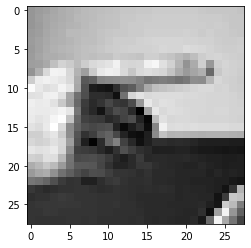

In [6]:
def to_image(array, label = True):
    # Reshape an array into an image format
    array = np.array(array)
    start_idx = 1 if label else 0
    return array[start_idx:].reshape(28,28).astype(float)
        
# Display one image
img = to_image(train_df.iloc[0])
plt.imshow(img, cmap = 'gray')
plt.show()

In [7]:
# The labels are coded in numbers. 
# Create a mapping to get the letters corresponding to the numbers
alphab = 'abcdefghijklmnopqrstuvwxyz'
mapping_letter = {}

for i,l in enumerate(alphab):
    mapping_letter[l] = i
mapping_letter = {v:k for k,v in mapping_letter.items()}

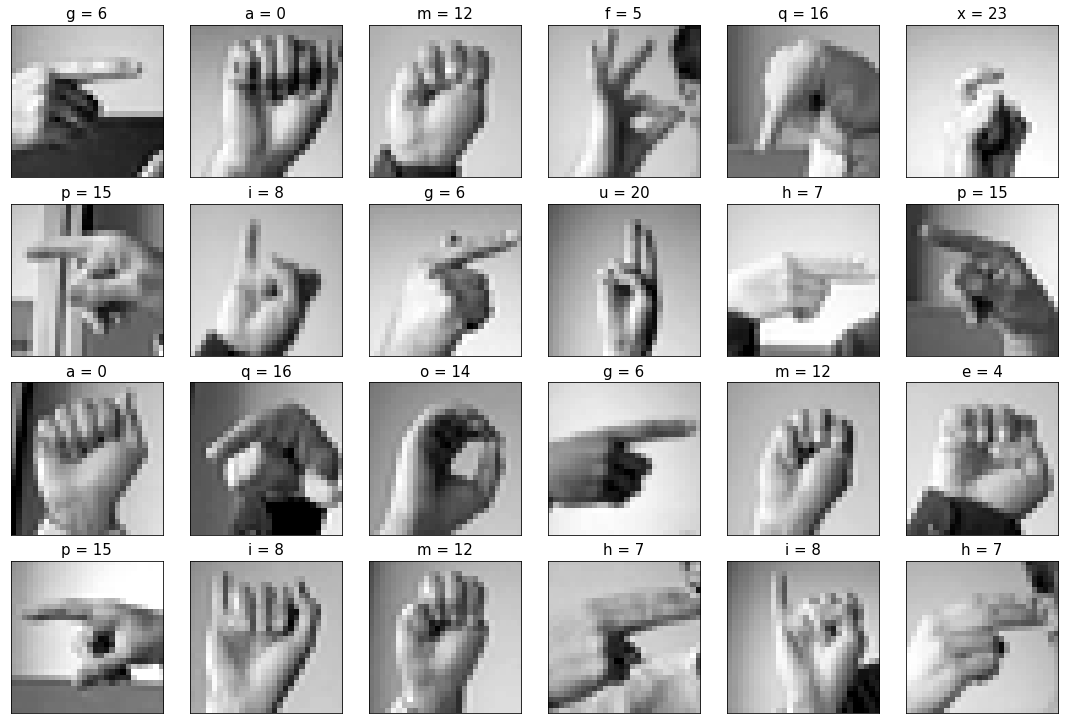

In [8]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = to_image(train_df.iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = mapping_letter[train_df.Label[i]] + " = " + str(train_df.Label[i])
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

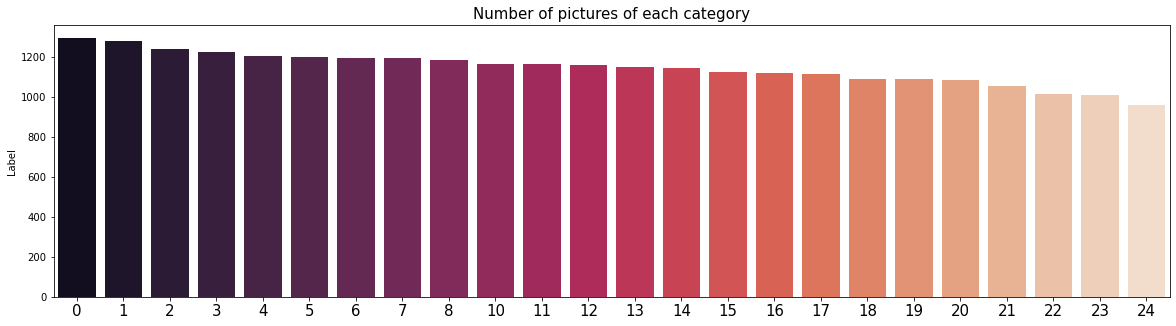

In [9]:
# Display the number of pictures of each letter
vc = train_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

# 2. Split the data and create the generator<a class="anchor" id="2"></a>

In [41]:
train_df_original = train_df.copy()

# Split into training, test and validation sets
val_index = int(train_df.shape[0]*0.1)
#10%
train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

y_train = train_df['Label']
y_val = val_df['Label']
y_test = test_df['Label']

# Reshape the traing and test set to use them with a generator
X_train = train_df.drop('Label',axis = 1).values.reshape(train_df.shape[0], 28, 28, 1)
X_val = val_df.drop('Label',axis = 1).values.reshape(val_df.shape[0], 28, 28, 1)
X_test = test_df.drop('Label',axis = 1).values.reshape(test_df.shape[0], 28, 28, 1)

In [53]:
# Display the shapes of the sets
X_train.shape, X_val.shape, X_test.shape

((22239, 28, 28, 1), (2471, 28, 28, 1), (7172, 28, 28, 1))

In [20]:
#data augmentation in case if we wanna add a bit more samples 
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))#to normalize the images 
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant") 
    return shifted_image.reshape([-1])


# Creating Augmented Dataset
X_train_augmented = []
y_train_augmented = []
for dx, dy in ((0,0),(1,0), (-1,0), (0,1), (0,-1)):
     for image, label in zip(X_train, y_train):
             X_train_augmented.append(shift_image(image, dx, dy))
             y_train_augmented.append(label)

#augmente data by x5 times 
augX = np.array(X_train_augmented)
augY = np.array(y_train_augmented)

In [23]:
augX.shape

(111195, 784)

In [34]:
#applying pca For n_components == ‘mle’, “Automatic choice of dimensionality for PCA”
X_train_reshaped = np.reshape(X_train,(24710,784))
pca2 = PCA(n_components='mle')
fitedPca = pca2.fit(X_train_reshaped[:2000],y_train)
print(pca2.explained_variance_ratio_)
fitedPca
 
 
 

[3.06852292e-01 9.86576159e-02 7.65346768e-02 4.98529304e-02
 3.44714049e-02 3.17187274e-02 2.74353634e-02 2.39079156e-02
 2.30331062e-02 1.74400793e-02 1.54757112e-02 1.41449608e-02
 1.32678203e-02 1.22165500e-02 1.03440231e-02 8.81672178e-03
 8.17239690e-03 7.54020620e-03 7.41027383e-03 6.52106428e-03
 5.86749333e-03 5.25641278e-03 5.14622178e-03 5.06252902e-03
 4.75551958e-03 4.38225368e-03 4.06299487e-03 3.84042296e-03
 3.71592840e-03 3.62821755e-03 3.58545232e-03 3.37328567e-03
 3.15511246e-03 3.11842679e-03 2.97227472e-03 2.81829028e-03
 2.73603058e-03 2.67023965e-03 2.61745435e-03 2.53802336e-03
 2.48754588e-03 2.30224960e-03 2.24432987e-03 2.21046912e-03
 2.18193771e-03 2.11115079e-03 2.04866182e-03 1.97196478e-03
 1.91314754e-03 1.85829701e-03 1.79713534e-03 1.76371331e-03
 1.72115551e-03 1.69309520e-03 1.65778131e-03 1.62410892e-03
 1.55587707e-03 1.50085688e-03 1.45800142e-03 1.44657907e-03
 1.43045432e-03 1.42355566e-03 1.37622277e-03 1.32843097e-03
 1.30875170e-03 1.264204

PCA(n_components='mle')

In [35]:
#save the pca model 
pk.dump(pca, open("pca.pkl","wb"))

In [8]:
# later reload the pickle file
pcatest = pk.load(open("pca.pkl",'rb'))
pcatest.transform(X_train[0].reshape(1,784)).shape
#there was a reductin by one dimention (one pixel )

(1, 783)

# 3 - Using Knn

In [29]:
#create the model 
knn = KNeighborsClassifier(n_neighbors=3)


In [43]:
#training the modeal
knn.fit(X_train.reshape(22239,784), y_train)


KNeighborsClassifier(n_neighbors=3)

In [45]:
#Predict the response for test dataset
Knny_pred = knn.predict(X_test.reshape(7172, 784))

In [46]:
#print("Accuracy:",metrics.accuracy_score(y_test, Knny_pred))
printmd(f'## {metrics.accuracy_score(y_test, Knny_pred)*100:.2f}% accuracy on the test set')

## 80.40% accuracy on the test set

In [27]:
augY
#Predict the response for test dataset with k = 3 
#load the model 
modelK3 = KNeighborsClassifier(n_neighbors=3)
modelK3.fit(pcatest.transform(augX), augY)

pred3 = modelK3.predict(pcatest.transform(X_test.reshape(7172, 784)))
#print("Accuracy:",metrics.accuracy_score(y_test, Knny_pred))
printmd(f'## {metrics.accuracy_score(y_test, pred3)*100:.2f}% accuracy on the Augmented test set with ')

## 81.27% accuracy on the Augmented test set with 

In [28]:
#save the model
dump(modelK3, 'knn3W200k.joblib') 

['knn3W200k.joblib']

In [9]:
#create the model 
kSpace = [3,5,7,9,11,13,15]
for k in kSpace :
    knn = KNeighborsClassifier(n_neighbors=k)
    #training the modeal
    knn.fit(pcatest.transform(X_train.reshape(24710,784)), y_train)
    #Predict the response for test dataset
    Knny_pred = knn.predict(pcatest.transform(X_test.reshape(7172, 784)))
    #save the model
    modelName = 'knnModel' + str(k) + '.joblib'
    dump(knn, modelName) 
    printmd(f'## {metrics.accuracy_score(y_test, Knny_pred)*100:.2f}% accuracy on the test set for k = ' + str(k))


## 80.28% accuracy on the test set for k = 3

## 80.47% accuracy on the test set for k = 5

## 79.80% accuracy on the test set for k = 7

## 79.32% accuracy on the test set for k = 9

## 78.83% accuracy on the test set for k = 11

## 78.57% accuracy on the test set for k = 13

## 77.76% accuracy on the test set for k = 15

In [56]:
#create the model 
kSpace = [3,5,7,9,11,13,15]
for k in kSpace :
    #load the model
    modelName = 'knnModel' + str(k) + '.joblib'
    model = load(modelName) 
    #training the modeal
    model.fit(pcatest.transform(X_train.reshape(22239,784)), y_train)
    #Predict the response for test dataset
    Knny_pred = knn.predict(pcatest.transform(X_train.reshape(22239,784)))
    printmd(f'## {metrics.accuracy_score(y_train, Knny_pred)*100:.2f}% accuracy on the train set for k = ' + str(k))

## 99.79% accuracy on the train set for k = 3

## 99.79% accuracy on the train set for k = 5

## 99.79% accuracy on the train set for k = 7

## 99.79% accuracy on the train set for k = 9

## 99.79% accuracy on the train set for k = 11

## 99.79% accuracy on the train set for k = 13

## 99.79% accuracy on the train set for k = 15

In [10]:
kSpace = [2,4,6,8,12,14,16]
for k in kSpace :
    knn = KNeighborsClassifier(n_neighbors=k)
    #training the modeal
    knn.fit(pcatest.transform(X_train.reshape(24710,784)), y_train)
    #Predict the response for test dataset
    Knny_pred = knn.predict(pcatest.transform(X_test.reshape(7172, 784)))
    #print("Accuracy:",metrics.accuracy_score(y_test, Knny_pred))
    #save the model
    modelName = 'knnModel' + str(k) + '.joblib'
    dump(knn, modelName) 
    printmd(f'## {metrics.accuracy_score(y_test, Knny_pred)*100:.2f}% accuracy on the test set for k = ' + str(k))


## 80.20% accuracy on the test set for k = 2

## 80.26% accuracy on the test set for k = 4

## 80.09% accuracy on the test set for k = 6

## 79.31% accuracy on the test set for k = 8

## 78.60% accuracy on the test set for k = 12

## 78.10% accuracy on the test set for k = 14

## 77.72% accuracy on the test set for k = 16

In [ ]:
#create the model 
kSpace = [2,4,6,8,12,14,16]
for k in kSpace :
    #load the model
    modelName = 'knnModel' + str(k) + '.joblib'
    model = load(modelName) 
    #training the modeal
    model.fit(pcatest.transform(X_train.reshape(22239,784)), y_train)
    #Predict the response for test dataset
    Knny_pred = knn.predict(pcatest.transform(X_train.reshape(22239,784)))
    printmd(f'## {metrics.accuracy_score(y_train, Knny_pred)*100:.2f}% accuracy on the train set for k = ' + str(k))

In [26]:
#save the model
dump(knn, 'knnWacp.joblib') 

['knnWacp.joblib']

In [90]:
#load the model 
model = load('knn.joblib') 

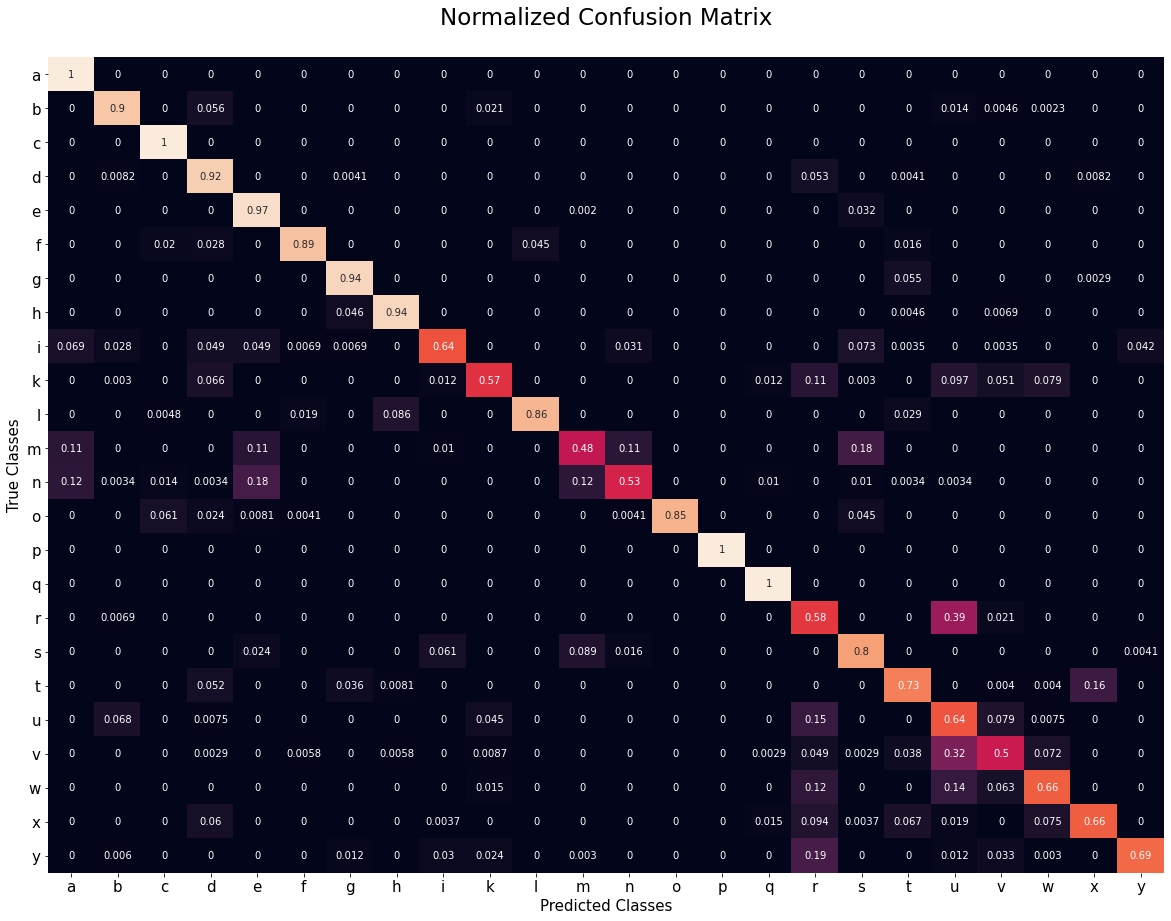

In [41]:
#confusion matrix for the knn 

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, Knny_pred , normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test_letters)), yticklabels = sorted(set(y_test_letters)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.show()

In [43]:
# Map the numbers into letters for the knn 
y_test_letters = [mapping_letter[x] for x in y_test]
pred_letters_knn = [mapping_letter[x] for x in Knny_pred]

# 4. Visualize the result <a class="anchor" id="4"></a>

In [44]:
print(classification_report(y_test_letters,pred_letters_knn))

              precision    recall  f1-score   support

           a       0.77      1.00      0.87       331
           b       0.92      0.90      0.91       432
           c       0.93      1.00      0.96       310
           d       0.68      0.92      0.78       245
           e       0.80      0.97      0.88       498
           f       0.96      0.89      0.92       247
           g       0.90      0.94      0.92       348
           h       0.95      0.94      0.95       436
           i       0.84      0.64      0.73       288
           k       0.84      0.57      0.68       331
           l       0.94      0.86      0.90       209
           m       0.76      0.48      0.59       394
           n       0.73      0.53      0.61       291
           o       1.00      0.85      0.92       246
           p       1.00      1.00      1.00       347
           q       0.93      1.00      0.96       164
           r       0.28      0.58      0.38       144
           s       0.61    